# Plot Paloma data

## Imports and setup

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from matplotlib.lines import Line2D

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

wandb.login()

True

## Get data from runs

In [14]:
api = wandb.Api()

RUN_SCALE = "tiny"

if RUN_SCALE == "tiny":
    relora_run = api.run("pico-lm/pico-relora/6vhmv4aj")
else:
    relora_run = api.run("pico-lm/pico-relora/5urfvs2j")

relora_df = pd.DataFrame(relora_run.scan_history())

In [15]:
def get_data_from_df(df: pd.DataFrame, every: int = 100, max_step: int = 20_000):
    global_step = df["trainer/global_step"]
    filtered = df.filter(like="by_phenomenon", axis=1).copy().dropna().drop_duplicates()
    filtered.columns = filtered.columns.map(lambda x: x.split(".")[1])
    filtered["step"] = global_step
    steps = filtered["step"]
    mask = (steps <= max_step) & (steps % every == 0)
    return filtered[mask]

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_82763/3354721676.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


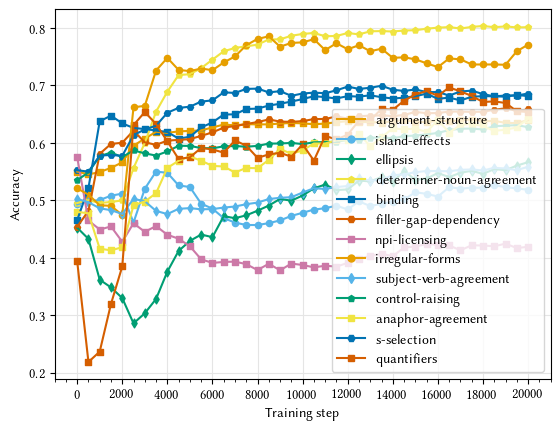

In [16]:
relora_data = get_data_from_df(relora_df, every=500)

fig, ax = plt.subplots()

colours = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
markers = ["s", "o", "d", "p", "s", "H"]

legend_elements = []

xs = relora_data["step"].to_numpy()

for idx, col in enumerate(relora_data.columns):
    if col == "step":
        continue
    ys = relora_data[col].to_numpy()

    colour = colours[idx % len(colours)]
    mark = markers[idx % len(markers)]

    ax.scatter(xs, ys, color=colour, marker=mark, s=20)
    ax.plot(xs, ys, color=colour)

    legend_elements.append(
        Line2D(
            [0],
            [0],
            color=colour,
            marker=mark,
            linestyle="-",
            label=col.replace("_", "-"),
            markersize=5,
        )
    )


ax.set_xlabel("Training step")
ax.set_ylabel("Accuracy")

ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.set_axisbelow(True)
ax.grid(which="major", axis="both", color="#E5E5E5")

ax.legend(handles=legend_elements)

fig.savefig(f"../graphs/{RUN_SCALE}_long_blimp.pdf")
fig.show()